In [21]:
import pickle
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [22]:
plt.close("all")  # close all previous plots

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
cache_path: str = "./cache/exp/"
data_frequency = "weekly"
start = "2000-01-01"
end = "2021-09-30"  # Data frequency and start/end dates
split_ratio_list = [0.6, 0.4]  # Train, validation and test split percentage
number_of_observe_per_window: int = 104
number_of_asset: int = 20  # Number of assets n_y = 20
AV_key: str = None

Device:  cuda


In [24]:
class TrainTest:
    def __init__(
        self,
        data: pd.DataFrame,
        number_of_observation_per_window: int,
        split_ratio_list: list[float],
    ) -> None:
        self.data: pd.DataFrame = data
        self.number_of_observation_per_window: int = number_of_observation_per_window
        self.split_ratio: list[float] = split_ratio_list

        num_total_observations: int = self.data.shape[
            0
        ]  # Calculate the total number of observations in the DataFrame
        num_observations_cumulative_split: list[float] = (
            num_total_observations * np.cumsum(split_ratio_list)
        )  # np.cumsum([0.7, 0.2, 0.1]) = [0.7, 0.9, 1.0]
        self.cumulative_number_window_observation: list[int] = [
            round(num_observation_cumulative_split)
            for num_observation_cumulative_split in num_observations_cumulative_split
        ]

    def split_update(self, split_ratio_list: list[float]) -> None:
        self.split_ratio: list[float] = split_ratio_list
        num_observations_total: int = self.data.shape[0]
        num_observations_cumulative_split: list[float] = (
            num_observations_total * np.cumsum(split_ratio_list)
        )  # np.cumsum([0.7, 0.2, 0.1]) = [0.7, 0.9, 1.0]
        self.cumulative_number_window_observation = [
            round(i) for i in num_observations_cumulative_split
        ]

    def train(self) -> pd.DataFrame:
        return self.data[
            : self.cumulative_number_window_observation[0]
        ]  # Return the training subset of observations

    def test(self):
        if (
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window
            < 0
        ):
            raise ValueError(
                "The number of observations per window exceeds the number of observations of train data in the dataset."
            )
        return self.data[
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window : self.cumulative_number_window_observation[
                1
            ]
        ]

    def shape(self):
        return self.data.shape

In [25]:
X_original_data: pd.DataFrame = pd.read_pickle(
    "./cache/factor_" + data_frequency + ".pkl"
)
Y_original_data: pd.DataFrame = pd.read_pickle(
    "./cache/asset_" + data_frequency + ".pkl"
)

In [26]:
X_original_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev
Date,,,,,,,,
2000-01-07,-0.024889,-0.003948,0.005921,-0.008655,0.021933,-0.033839,0.034927,0.002774
2000-01-14,0.020696,0.013858,-0.015028,-0.028196,0.000918,0.015969,-0.001553,0.008910
2000-01-21,0.000378,0.060555,-0.025968,-0.048690,0.001365,0.053417,-0.043407,0.020229
2000-01-28,-0.057084,0.009003,0.016956,0.013910,0.016216,-0.030094,0.031843,-0.012653
2000-02-04,0.044559,-0.001065,-0.026655,-0.019944,-0.014198,0.037680,-0.001666,0.015425


In [27]:
Y_original_data.head()

,AAPL,MSFT,AMZN,C,JPM,BAC,XOM,HAL,MCD,WMT,COST,CAT,LMT,JNJ,PFE,DIS,VZ,T,ED,NEM
date,,,,,,,,,,,,,,,,,,,,
2000-01-07,-0.032195,-0.045482,-0.086300,-0.030347,-0.058169,-0.029886,0.054369,0.010932,-0.010667,-0.009113,0.019836,0.132809,-0.020110,0.034853,0.063502,0.064274,-0.038464,-0.089726,0.045217,-0.124898
2000-01-14,0.009447,0.007268,-0.076337,0.074074,0.015533,0.037174,-0.014010,-0.052347,0.068455,-0.058394,0.054374,-0.025699,-0.043843,-0.029119,0.072464,0.078060,-0.042510,-0.048266,-0.065724,-0.029384
2000-01-21,0.108224,-0.075724,-0.034086,-0.026897,-0.012723,-0.095248,0.014925,0.099066,-0.036376,-0.031938,-0.011415,-0.081857,0.024390,-0.040666,-0.052432,-0.024136,0.066596,0.023810,-0.003859,0.018260
2000-01-28,-0.087054,-0.053012,-0.005962,-0.005493,0.051412,0.001313,-0.072000,-0.155026,-0.104968,-0.117072,-0.051546,-0.081891,-0.100952,-0.059858,0.003708,0.122137,-0.040460,-0.087209,-0.029797,-0.053327
2000-02-04,0.062783,0.084580,0.273464,-0.021814,0.065980,0.002842,0.025355,0.027925,-0.044354,0.021404,0.152174,-0.027356,0.013242,-0.028047,0.015914,0.037551,0.016137,0.070064,-0.009521,0.196411


In [28]:
import time


def AV(
    start: str,
    end: str,
    split_ratio: list,
    data_frequency: str = "weekly",
    num_observations_per_window: int = 104,
    num_assets=None,
    use_cache: bool = False,
    save_results: bool = False,
    AV_key: str = None,
):
    if use_cache:
        X: pd.DataFrame = pd.read_pickle("./cache/factor_" + data_frequency + ".pkl")
        Y: pd.DataFrame = pd.read_pickle("./cache/asset_" + data_frequency + ".pkl")
    else:
        raise ValueError(
            "We cannot download data from AlphaVantage without an API key."
        )

    # Partition dataset into training and testing sets. Lag the data by one observation, since we are predicting future returns, so we don't need the last observation that doesn't have a future return.
    # we don't need the first Y observation that doesn't have a corresponding X observation.
    return TrainTest(X[:-1], num_observations_per_window, split_ratio), TrainTest(
        Y[1:], num_observations_per_window, split_ratio
    )

In [29]:
X_data, Y_data = AV(
    start,
    end,
    split_ratio_list,
    data_frequency=data_frequency,
    num_observations_per_window=number_of_observe_per_window,
    num_assets=number_of_asset,
    use_cache=True,
    save_results=False,
    AV_key=AV_key,
)
print(X_data.shape())
print(X_data.train().shape)
print(Y_data.train().shape)

(1134, 8)
(680, 8)
(680, 20)


In [30]:
# Number of features and assets
n_X: int = X_data.train().shape[1]
n_Y: int = Y_data.train().shape[1]
print("Number of features: ", n_X)
print("Number of assets: ", n_Y)

Number of features:  8
Number of assets:  20


Low p-values (< 0.05) suggest that the factor significantly affects the stock returns.
High p-values (> 0.05) suggest that the factor's effect on the stock returns is not statistically significant.

In [31]:
import statsmodels.api as sm


def statanalysis(X: pd.DataFrame, Y: pd.DataFrame) -> pd.DataFrame:
    # Initialize an empty DataFrame to store p-values
    # Rows correspond to assets (Y.columns) and columns correspond to features (X.columns)
    stats = pd.DataFrame(
        columns=X.columns, index=Y.columns
    )  # Create an empty DataFrame to store the p-values
    for ticker in Y.columns:
        for feature in X.columns:
            stats.loc[ticker, feature] = (
                sm.OLS(Y[ticker].values, sm.add_constant(X[feature]).values)
                .fit()
                .pvalues[1]  # Get the p-value of the feature
            )

    return stats.astype(float).round(2)


statistical_analysis: pd.DataFrame = statanalysis(X_data.train(), Y_data.train())
print(statistical_analysis)

      Mkt-RF   SMB   HML   RMW   CMA  Mom     ST_Rev  LT_Rev
AAPL    0.34  0.37  0.53  0.92  0.70    0.41    0.41    0.53
MSFT    0.64  0.85  0.63  0.80  0.20    0.21    0.97    0.22
AMZN    0.31  0.02  0.64  0.28  0.63    0.18    0.45    0.34
C       0.25  0.69  0.02  0.04  0.21    0.07    0.02    0.24
JPM     0.33  0.64  0.00  0.50  0.48    0.18    0.18    0.01
BAC     0.16  0.91  0.01  0.16  0.56    0.15    0.06    0.19
XOM     0.03  0.77  0.34  0.15  0.10    0.11    0.51    0.04
HAL     0.92  0.48  0.47  0.14  0.14    0.42    0.92    0.05
MCD     0.48  0.05  0.57  0.02  0.54    0.27    0.81    0.03
WMT     0.00  0.01  0.25  0.00  0.40    0.62    0.04    0.03
COST    0.00  0.22  0.85  0.01  0.38    0.66    0.39    0.05
CAT     0.92  0.27  0.59  0.23  0.07    0.40    0.67    0.51
LMT     0.27  0.74  0.04  0.00  0.61    0.32    0.38    0.60
JNJ     0.00  0.91  0.39  0.09  0.84    0.82    0.19    0.06
PFE     0.06  0.38  0.95  0.91  0.56    0.75    0.50    0.12
DIS     0.35  0.67  0.82

In [32]:
import cvxpy as cp
from torch.utils.data import Dataset


class SlidingWindow(Dataset):
    """Sliding window dataset constructor for time series data."""

    def __init__(
        self,
        XData: pd.DataFrame,
        YData: pd.DataFrame,
        num_observations: int,
        performance_window: int,
    ) -> None:
        # Convert the feature DataFrame to a PyTorch tensor with double precision
        self.X: torch.Tensor = torch.tensor(XData.values, dtype=torch.float64)
        # Convert the asset return DataFrame to a PyTorch tensor with double precision
        self.Y: torch.Tensor = torch.tensor(YData.values, dtype=torch.float64)
        # Store the number of observations (scenarios) in the sliding window
        self.num_observations: int = num_observations
        # Store the number of scenarios in the performance window
        self.perf_period: int = performance_window

    def __getitem__(
        self, index: int
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Extract the feature window starting at 'index' and spanning 'n_obs + 1' time steps
        x: torch.Tensor = self.X[index : index + self.num_observations + 1]
        # Extract the realizations window starting at 'index' and spanning 'n_obs' time steps
        y: torch.Tensor = self.Y[index : index + self.num_observations]
        # Extract the performance window starting after the observations window and spanning 'perf_period + 1' time steps
        y_future_performance: torch.Tensor = self.Y[
            index
            + self.num_observations : index
            + self.num_observations
            + self.perf_period
            + 1
        ]
        # Return the extracted windows as a tuple
        return x, y, y_future_performance

    def __len__(self) -> int:
        # Calculate the effective length by subtracting the window sizes from the total data length
        total_length: int = len(self.X) - self.num_observations - self.perf_period
        # Return the calculated length
        return total_length

In [33]:
class BackTest:
    """Backtest object to store out-of-sample results."""

    def __init__(self, len_test: int, n_y: int, dates: pd.DatetimeIndex) -> None:
        # Initialize the weights array with zeros; dimensions are (len_test, n_y)
        self.weights: np.ndarray = np.zeros((len_test, n_y))
        # Initialize the returns array with zeros; length is len_test
        self.rets: np.ndarray = np.zeros(len_test)
        # Store the dates corresponding to the out-of-sample period
        self.dates: pd.DatetimeIndex = pd.DatetimeIndex(dates[-len_test:])

    def stats(self) -> None:
        # Calculate the cumulative product of returns plus one to get the total return index
        tri: np.ndarray = np.cumprod(self.rets + 1)
        # Calculate the geometric mean return over the out-of-sample period
        self.mean: float = (tri[-1]) ** (1 / len(tri)) - 1
        # Calculate the volatility (standard deviation) of the returns
        self.vol: float = np.std(self.rets)
        # Calculate the pseudo-Sharpe ratio, handling division by zero
        self.sharpe: float = self.mean / self.vol if self.vol != 0 else np.nan
        # Create a DataFrame with dates, realized returns, and total return index
        self.returns = pd.DataFrame({"Date": self.dates, "rets": self.rets, "tri": tri})
        # Set the 'Date' column as the index of the DataFrame
        self.returns = self.returns.set_index("Date")

    def plot_cumulative_returns(
        self,
        figsize: tuple = (12, 6),
        resample_freq: str | None = None,
        title: str | None = None,
    ) -> None:
        if self.returns is None:
            raise ValueError(
                "Returns DataFrame not initialized. Run 'compute_stats' after populating 'rets' and 'weights'."
            )

        data_to_plot = self.returns["tri"]
        label = "Cumulative Return"

        if resample_freq:
            # Resample the cumulative return
            # For cumulative returns, resampling can be tricky. We'll resample the returns first,
            # then compute cumulative returns on the resampled data.
            resampled_rets = (
                self.returns["rets"]
                .resample(resample_freq)
                .apply(lambda x: (x + 1).prod() - 1)
            )
            data_to_plot = (resampled_rets + 1).cumprod()
            label = f"Cumulative Return ({resample_freq})"

        plt.figure(figsize=figsize)
        plt.plot(data_to_plot, label=label, color="blue")
        plt.title(title if title else "Cumulative Return Over Time")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.show()

In [34]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer


# Define the Sharpe loss function
def sharpe_loss(z_star: torch.Tensor, y_perf: torch.Tensor) -> torch.Tensor:
    loss = -torch.mean(y_perf @ z_star) / torch.std(y_perf @ z_star)
    return loss


# Define the portfolio variance risk function
def p_var(z: cp.Variable, c: cp.Variable, x: cp.Expression) -> cp.Expression:
    return cp.square(x @ z - c)


# Define the Hellinger distance-based DRO optimization layer
def hellinger(num_assets: int, num_observations: int, prisk) -> CvxpyLayer:
    # Define decision variables
    z = cp.Variable((num_assets, 1), nonneg=True)  # Portfolio weights
    c_aux = cp.Variable()  # Centering parameter
    lambda_aux = cp.Variable(nonneg=True)
    xi_aux = cp.Variable()
    beta_aux = cp.Variable(num_observations, nonneg=True)
    tau_aux = cp.Variable(num_observations, nonneg=True)
    mu_aux = cp.Variable()

    # Define parameters
    ep = cp.Parameter((num_observations, num_assets))  # Residuals matrix
    y_hat = cp.Parameter(num_assets)  # Predicted returns
    gamma = cp.Parameter(nonneg=True)  # Risk-return trade-off parameter
    delta = cp.Parameter(nonneg=True)  # Ambiguity size parameter

    # Define constraints
    constraints = [
        cp.sum(z) == 1,  # Total budget constraint
        mu_aux == y_hat @ z,  # Expected return constraint
    ]
    for i in range(num_observations):
        # Constraints based on the risk function
        constraints += [xi_aux + lambda_aux >= prisk(z, c_aux, ep[i, :]) + tau_aux[i]]
        constraints += [
            beta_aux[i] >= cp.quad_over_lin(lambda_aux, tau_aux[i])
        ]  # Constraint on the ambiguity set

    # Define the objective function
    objective = cp.Minimize(
        xi_aux
        + (delta - 1) * lambda_aux
        + (1 / num_observations) * cp.sum(beta_aux)
        - gamma * mu_aux
    )

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Create a CVXPY layer
    cvxpylayer = CvxpyLayer(
        problem, parameters=[ep, y_hat, gamma, delta], variables=[z]
    )

    return cvxpylayer


# Define mappings for performance loss functions, risk functions, and optimization layers
perf_loss_functions = {
    "sharpe_loss": sharpe_loss,
    # Add other performance loss functions here if needed
}

risk_functions = {
    "p_var": p_var,
    # Add other risk functions here if needed
}

opt_layer_functions = {
    "hellinger": hellinger,
    # Add other optimization layer functions here if needed
}

In [35]:
import pandas as pd
import numpy as np
from typing import Dict, Any


def compute_annualized_sharpe_ratio(
    returns: pd.Series | np.ndarray,
    risk_free_rate: float = 0.02,
    periods_per_year: int = 52,
) -> float:
    """
    Compute the annualized Sharpe Ratio.

    Args:
        returns (pd.Series | np.ndarray): Periodic returns of the portfolio.
        risk_free_rate (float, optional): Annual risk-free rate (e.g., 0.02 for 2%). Defaults to 0.02.
        periods_per_year (int, optional): Number of return periods in a year (e.g., 52 for weekly). Defaults to 52.

    Returns:
        float: Annualized Sharpe Ratio.
    """
    if isinstance(returns, pd.Series):
        returns = returns.dropna().values
    else:
        returns = np.array(returns)
        returns = returns[~np.isnan(returns)]

    if len(returns) == 0:
        return np.nan

    # Calculate excess returns by subtracting the per-period risk-free rate
    excess_returns = returns - (risk_free_rate / periods_per_year)

    # Calculate mean and standard deviation of excess returns
    mean_excess_return = np.mean(excess_returns) * periods_per_year  # Annualize mean
    std_excess_return = np.std(excess_returns, ddof=1) * np.sqrt(
        periods_per_year
    )  # Annualize std

    # Compute Sharpe Ratio with numerical stability
    sharpe_ratio = mean_excess_return / (
        std_excess_return + 1e-18
    )  # Add epsilon to prevent division by zero

    return sharpe_ratio


def analyze_returns(
    returns: pd.DataFrame, risk_free_rate: float = 0.02, frequency: int = 52
) -> Dict[str, Any]:
    """
    Analyze the returns DataFrame to verify date index, count total weeks,
    identify years covered, count weeks per year, and compute Sharpe Ratio per year.

    Args:
        returns (pd.DataFrame): DataFrame containing portfolio returns with a DatetimeIndex.
        risk_free_rate (float, optional): Annual risk-free rate (default is 2%). Defaults to 0.02.
        frequency (int, optional): Number of periods per year (default is 52 for weekly data). Defaults to 52.

    Returns:
        Dict[str, Any]: Dictionary containing analysis results.
    """
    analysis_results: Dict[str, Any] = {}

    # 1. Verify that the DataFrame is indexed by dates
    if not isinstance(returns.index, pd.DatetimeIndex):
        raise TypeError("The DataFrame index must be a pandas DatetimeIndex.")
    analysis_results["DateIndexValid"] = True

    # 2. Count the total number of weeks
    total_weeks: int = len(returns)
    analysis_results["TotalWeeks"] = total_weeks

    # 3. Identify all the years covered in the dataset
    years: list[int] = returns.index.year.unique().tolist()
    years.sort()  # Sort the years in ascending order
    analysis_results["YearsCovered"] = years

    # 4. Count the number of weeks for each individual year
    weeks_per_year: Dict[int, int] = {}
    grouped = returns.groupby(returns.index.year)

    for year, group in grouped:
        weeks_count = len(group)
        weeks_per_year[year] = weeks_count

    analysis_results["WeeksPerYear"] = weeks_per_year

    # 5. Compute Sharpe Ratio for each year
    sharpe_ratios_per_year: Dict[int, float] = {}
    for year, group in grouped:
        sharpe = compute_annualized_sharpe_ratio(
            returns=group["rets"],
            risk_free_rate=risk_free_rate,
            periods_per_year=analysis_results["WeeksPerYear"][year],
        )
        sharpe_ratios_per_year[year] = sharpe

    analysis_results["SharpeRatiosPerYear"] = sharpe_ratios_per_year

    return analysis_results

In [36]:
class E2E_net_Eps_Control(nn.Module):
    """End-to-end Distributionally Robust Optimization (DRO) learning neural net module."""

    def __init__(
        self,
        num_input_features: int,
        num_assets: int,
        num_observations: int,
        optimization_layer: str = "hellinger",
        prisk: str = "p_var",
        performance_objective: str = "sharpe_loss",
        pred_model: str = "3layer",
        prediction_loss_factor: float | None = 0.5,
        performance_period: int = 13,
        train_pred: bool = True,
        train_gamma: bool = True,
        train_delta: bool = True,
        set_seed: int | None = None,
        cache_path: str = "./cache/",
        self_overall_std_dev_factor: float = 1.0,
        model_name: str = "E2E_net_Eps_Control",
    ) -> None:
        super(E2E_net_Eps_Control, self).__init__()

        # Set random seed for reproducibility
        if set_seed is not None:
            torch.manual_seed(set_seed)
            self.seed: int = set_seed

        self.num_features: int = num_input_features  # Number of input features
        self.num_assets: int = num_assets  # Number of assets
        self.num_observations: int = (
            num_observations  # Number of observations/scenarios
        )

        # Prediction loss function
        if prediction_loss_factor is not None:
            self.pred_loss_factor: float = prediction_loss_factor
            self.pred_loss = nn.MSELoss()  # Mean squared error loss
        else:
            self.pred_loss = None

        # Performance loss function
        if performance_objective in perf_loss_functions:
            self.perf_loss = perf_loss_functions[performance_objective]
        else:
            raise ValueError(f"Unknown perf_loss function: {performance_objective}")

        self.perf_period: int = performance_period

        # Initialize gamma parameter
        self.gamma: nn.Parameter = nn.Parameter(
            torch.FloatTensor(1).uniform_(0.02, 0.1)
        )
        self.gamma.requires_grad = train_gamma
        self.gamma_init: float = self.gamma.item()

        ub: float = (1 - 1 / (num_observations**0.5)) / 2
        lb: float = (1 - 1 / (num_observations**0.5)) / 10
        self.delta: nn.Parameter = nn.Parameter(torch.FloatTensor(1).uniform_(lb, ub))
        self.delta.requires_grad = train_delta
        self.delta_init: float = self.delta.item()
        self.model_type = "dro"

        self.pred_model: str = pred_model

        if pred_model == "2layer":
            hidden_size = int(0.5 * (num_input_features + num_assets))
            self.pred_layer = nn.Sequential(
                nn.Linear(num_input_features, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, num_assets),
                nn.ReLU(),
                nn.Linear(num_assets, num_assets),
            )
        elif pred_model == "3layer":
            hidden_size1 = int(0.5 * (num_input_features + num_assets))
            hidden_size2 = int(0.6 * (num_input_features + num_assets))
            self.pred_layer = nn.Sequential(
                nn.Linear(num_input_features, hidden_size1),
                nn.ReLU(),
                nn.Linear(hidden_size1, hidden_size2),
                nn.ReLU(),
                nn.Linear(hidden_size2, num_assets),
                nn.ReLU(),
                nn.Linear(num_assets, num_assets),
            )
        else:
            raise ValueError(f"Unknown pred_model type: {pred_model}")

        # Define the optimization layer
        if optimization_layer in opt_layer_functions:
            if prisk in risk_functions:
                self.opt_layer = opt_layer_functions[optimization_layer](
                    num_assets, num_observations, risk_functions[prisk]
                )
            else:
                raise ValueError(f"Unknown prisk function: {prisk}")
        else:
            raise ValueError(f"Unknown opt_layer function: {optimization_layer}")

        self.cache_path: str = cache_path

        self.overall_std_dev_factor: float = self_overall_std_dev_factor
        self.model_name: str = model_name

    def forward(
        self, X: torch.Tensor, Y: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # Generate predictions for each time step in X
        Y_hat: torch.Tensor = self.pred_layer(X)  # Shape: (n_obs + 1, n_y)
        # Calculate residuals
        ep: torch.Tensor = Y - Y_hat[:-1]  # Shape: (n_obs, n_y)
        # Calculate overall standard deviation (scalar)
        self.overall_eps_std_dev: torch.Tensor = (
            torch.std(ep, unbiased=True).to("cpu").detach().numpy()
        )

        # Extract the last prediction
        y_hat: torch.Tensor = Y_hat[-1]  # Shape: (n_y,)

        # Solver arguments
        solver_args: Dict[str, Any] = {
            "solve_method": "ECOS",
            "max_iters": 120,
            "abstol": 1e-7,
        }

        # Optimize z_star
        z_star: torch.Tensor
        (z_star,) = self.opt_layer(
            ep, y_hat, self.gamma, self.delta, solver_args=solver_args
        )

        return z_star, y_hat

    def net_train(
        self,
        train_set: DataLoader,
        val_set: DataLoader | None = None,
        epochs: int | None = None,
        lr: float | None = None,
    ) -> float | None:
        # Assign number of epochs and learning rate
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        n_train: int = len(train_set)
        self.train()
        for epoch in range(epochs):
            train_loss: float = 0.0
            optimizer.zero_grad()
            for _, (x, y, y_perf) in enumerate(train_set):
                # Move tensors to the same device as the model
                x = x.to(next(self.parameters()).device)
                y = y.to(next(self.parameters()).device)
                y_perf = y_perf.to(next(self.parameters()).device)

                # Forward pass
                z_star, y_hat = self(x.squeeze(), y.squeeze())

                # Compute loss
                if self.pred_loss is None:
                    loss = (1 / n_train) * self.perf_loss(z_star, y_perf.squeeze())
                else:
                    loss = (1 / n_train) * (
                        self.perf_loss(z_star, y_perf.squeeze())
                        + (self.pred_loss_factor / self.num_assets)
                        * self.pred_loss(y_hat, y_perf.squeeze()[0])
                        + (
                            self.overall_std_dev_factor
                            # / self.num_assets
                            # / self.num_observations
                        )
                        * self.overall_eps_std_dev
                    )

                # Backward pass
                loss.backward()

                # Accumulate loss
                train_loss += loss.item()

            # Update parameters
            optimizer.step()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

            # Ensure gamma and delta remain positive
            for name, param in self.named_parameters():
                if name == "gamma":
                    param.data.clamp_(min=0.0001)

        # Validation
        if val_set is not None:
            n_val: int = len(val_set)
            val_loss: float = 0.0
            self.eval()
            with torch.no_grad():
                for t, (x, y, y_perf) in enumerate(val_set):
                    # Forward pass
                    z_val, y_val = self(x.squeeze(), y.squeeze())

                    # Compute loss
                    if self.pred_loss is None:
                        loss = (1 / n_val) * self.perf_loss(z_val, y_perf.squeeze())
                    else:
                        loss = (1 / n_val) * (
                            self.perf_loss(z_val, y_perf.squeeze())
                            + (self.pred_loss_factor / self.num_assets)
                            * self.pred_loss(y_val, y_perf.squeeze()[0])
                            + (
                                self.overall_std_dev_factor
                                # / self.num_assets
                                # / self.num_observations
                            )
                            * self.overall_eps_std_dev
                        )

                    # Accumulate validation loss
                    val_loss += loss.item()

            return val_loss

    # -----------------------------------------------------------------------------------------------
    # net_roll_test: Test the e2e neural net
    # -----------------------------------------------------------------------------------------------
    def net_roll_test(
        self,
        X: TrainTest,
        Y: TrainTest,
        n_roll: int,
        lr: float,
        epochs: int,
        load_state: list[bool] = [False, False, False, False],
        save_state: list[bool] = [False, False, False, False],
    ) -> None:
        # Initialize backtest object
        portfolio = BackTest(
            len(Y.test()) - Y.number_of_observation_per_window,
            self.num_assets,
            Y.test().index[Y.number_of_observation_per_window :],
        )

        # Initialize lists to store trained parameters
        self.gamma_trained = []
        self.delta_trained = []

        # Store initial split
        init_split = Y.split_ratio

        # Calculate window size
        win_size = init_split[1] / n_roll

        split = [0, 0]
        t = 0
        for i in range(n_roll):

            print(f"Out-of-sample window: {i+1} / {n_roll}")

            split[0] = init_split[0] + win_size * i
            if i < n_roll - 1:
                split[1] = win_size
            else:
                split[1] = 1 - split[0]

            X.split_update(split)
            Y.split_update(split)
            train_set = DataLoader(
                SlidingWindow(
                    X.train(), Y.train(), self.num_observations, self.perf_period
                )
            )
            test_set = DataLoader(
                SlidingWindow(X.test(), Y.test(), self.num_observations, 0)
            )
            if load_state[i]:
                # Reset model parameters to initial state
                self.load_state_dict(
                    torch.load(
                        self.cache_path + self.model_name + "_model_" + str(i) + ".pt",
                        weights_only=True,
                    )
                )
            # Train the model
            self.train()
            self.net_train(train_set, lr=lr, epochs=epochs)
            # Save the trained model
            if save_state[i]:
                torch.save(
                    self.state_dict(),
                    self.cache_path + self.model_name + "_model_" + str(i) + ".pt",
                )
            self.gamma_trained.append(self.gamma.item())
            self.delta_trained.append(self.delta.item())
            # Test the model
            self.eval()
            with torch.no_grad():
                for __, (x, y, y_perf) in enumerate(test_set):
                    # Move tensors to the same device as the model
                    x = x.to(next(self.parameters()).device)
                    y = y.to(next(self.parameters()).device)
                    y_perf = y_perf.to(next(self.parameters()).device)

                    z_star, _ = self(x.squeeze(), y.squeeze())
                    if not np.isclose(torch.sum(z_star).cpu().numpy(), 1.0, atol=1e-2):
                        print(z_star)

                    portfolio.weights[t] = z_star.squeeze().cpu().numpy()
                    portfolio.rets[t] = (
                        y_perf.squeeze().cpu().numpy() @ portfolio.weights[t]
                    ).item()
                    t += 1

        # Reset dataset splits
        X.split_update(init_split)
        Y.split_update(init_split)

        # Calculate portfolio statistics
        portfolio.stats()
        self.portfolio = portfolio

    # -----------------------------------------------------------------------------------------------
    # load_cv_results: Load cross-validation results
    # -----------------------------------------------------------------------------------------------
    def load_cv_results(self, cv_results):
        self.cv_results = cv_results

        # Select and store the optimal hyperparameters
        idx = cv_results.val_loss.idxmin()
        self.lr = cv_results.lr[idx]
        self.epochs = cv_results.epochs[idx]

In [37]:
n_roll: int = 4  # Number of rolling windows
dr_net_eps_0 = E2E_net_Eps_Control(
    num_input_features=n_X,
    num_assets=n_Y,
    num_observations=number_of_observe_per_window,
    prisk="p_var",
    train_pred=True,
    train_gamma=True,
    train_delta=True,
    set_seed=19260817,
    optimization_layer="hellinger",
    performance_objective="sharpe_loss",
    cache_path="./cache/",
    performance_period=13,
    prediction_loss_factor=0.5,
    self_overall_std_dev_factor=0,
    model_name="E2E_net_Eps_Control_0",
).double()
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
dr_net_eps_0.to(device)
dr_net_eps_0.net_roll_test(
    X_data,
    Y_data,
    n_roll=n_roll,
    lr=0.005,
    epochs=60,
    load_state=[True] * (n_roll),
    save_state=[True] * (n_roll),
)
portfolio_0 = dr_net_eps_0.portfolio

Device:  cuda
Out-of-sample window: 1 / 4


c:\Users\zhang\anaconda3\envs\py12\Lib\site-packages\diffcp\cone_program.py:371: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


Epoch 1/60, Loss: -0.3694
Epoch 2/60, Loss: -0.3107
Epoch 3/60, Loss: -0.3493
Epoch 4/60, Loss: -0.3493
Epoch 5/60, Loss: -0.3337
Epoch 6/60, Loss: -0.3385
Epoch 7/60, Loss: -0.3469
Epoch 8/60, Loss: -0.3533
Epoch 9/60, Loss: -0.3562
Epoch 10/60, Loss: -0.3501
Epoch 11/60, Loss: -0.3472
Epoch 12/60, Loss: -0.3519
Epoch 13/60, Loss: -0.3589
Epoch 14/60, Loss: -0.3628
Epoch 15/60, Loss: -0.3628
Epoch 16/60, Loss: -0.3616
Epoch 17/60, Loss: -0.3608
Epoch 18/60, Loss: -0.3602
Epoch 19/60, Loss: -0.3621
Epoch 20/60, Loss: -0.3649
Epoch 21/60, Loss: -0.3655
Epoch 22/60, Loss: -0.3646
Epoch 23/60, Loss: -0.3656
Epoch 24/60, Loss: -0.3674
Epoch 25/60, Loss: -0.3688
Epoch 26/60, Loss: -0.3693
Epoch 27/60, Loss: -0.3674
Epoch 28/60, Loss: -0.3693
Epoch 29/60, Loss: -0.3701
Epoch 30/60, Loss: -0.3701
Epoch 31/60, Loss: -0.3700
Epoch 32/60, Loss: -0.3706
Epoch 33/60, Loss: -0.3710
Epoch 34/60, Loss: -0.3714
Epoch 35/60, Loss: -0.3717
Epoch 36/60, Loss: -0.3719
Epoch 37/60, Loss: -0.3725
Epoch 38/6

In [38]:
print("Sharpe Ratio: ", portfolio_0.sharpe)
print("Mean Return: ", portfolio_0.mean)
print("Volatility: ", portfolio_0.vol)
print("Annualized Sharpe Ratio: ", portfolio_0.sharpe * np.sqrt(52))

Sharpe Ratio:  0.17236529318423396
Mean Return:  0.003694613518108625
Volatility:  0.021434788000851242
Annualized Sharpe Ratio:  1.2429438053722783


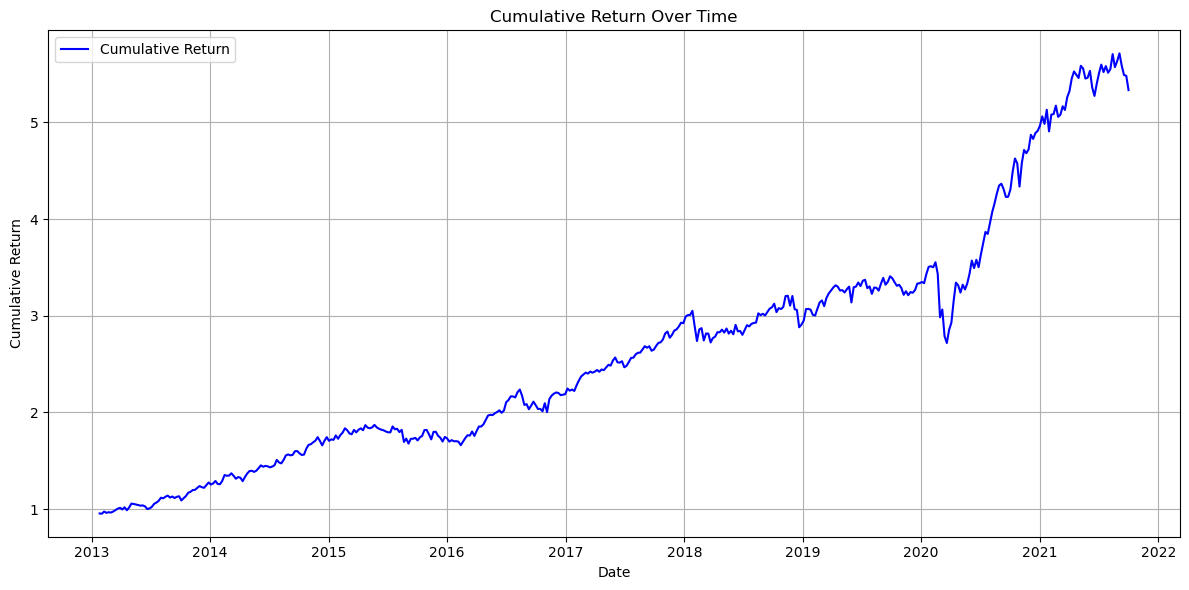

In [39]:
portfolio_0.plot_cumulative_returns()

In [40]:
import os
from typing import List, Optional, Tuple

import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

# Assuming TrainTest is defined elsewhere in your codebase
# from your_module import TrainTest


def AV_yFinance(
    start: str,
    end: str,
    split: List[float],
    freq: str = "weekly",
    n_obs: int = 104,
    n_y: Optional[int] = None,
    use_cache: bool = False,
    save_results: bool = False,
) -> Tuple[TrainTest, TrainTest]:

    if use_cache:
        X = pd.read_pickle(f"./cache/factor_{freq}.pkl")
        Y = pd.read_pickle(f"./cache/asset_{freq}.pkl")
    else:
        # Define the list of tickers
        tick_list = [
            "AAPL",
            "MSFT",
            "AMZN",
            "C",
            "JPM",
            "BAC",
            "XOM",
            "HAL",
            "MCD",
            "WMT",
            "COST",
            "CAT",
            "LMT",
            "JNJ",
            "PFE",
            "DIS",
            "VZ",
            "T",
            "ED",
            "NEM",
        ]

        if n_y is not None:
            tick_list = tick_list[:n_y]

        # Download asset data using yfinance
        data = yf.download(
            tick_list,
            start=start,
            end=end,
            progress=False,
            group_by="ticker",
            auto_adjust=True,  # Adjusted close prices
            threads=True,  # Enable multi-threading for faster downloads
        )

        if data.empty:
            raise ValueError(
                "No data downloaded. Please check the ticker symbols and date range."
            )

        # Extract Adjusted Close prices
        if len(tick_list) == 1:
            # For single ticker, data['Close'] is a Series, convert to DataFrame
            adj_close = data["Close"].to_frame()
            adj_close.columns = tick_list
        else:
            # For multiple tickers, use xs to extract 'Close' for all tickers
            try:
                adj_close = data.xs("Close", level=1, axis=1)
            except KeyError:
                raise KeyError("Close prices not found in the downloaded data.")

        # Compute daily returns as percentage change
        Y = adj_close.pct_change().dropna()

        # Download factor data from Kenneth French's data library
        dl_freq = "_daily"

        try:
            # 5-Factor Model
            factor_5 = pdr.get_data_famafrench(
                "F-F_Research_Data_5_Factors_2x3" + dl_freq,
                start=start,
                end=end,
            )[0]
            rf_df = factor_5["RF"]
            factor_5 = factor_5.drop(["RF"], axis=1)

            # Momentum Factor
            mom_df = pdr.get_data_famafrench(
                "F-F_Momentum_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Short-Term Reversal Factor
            st_df = pdr.get_data_famafrench(
                "F-F_ST_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Long-Term Reversal Factor
            lt_df = pdr.get_data_famafrench(
                "F-F_LT_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Concatenate all factors and convert to decimal
            X = pd.concat([factor_5, mom_df, st_df, lt_df], axis=1) / 100
        except Exception as e:
            raise ValueError(f"Failed to download factor data: {e}")

        # Align factor data (X) with asset returns (Y) based on dates

        # Remove timezone from Y.index if present
        if Y.index.tz is not None:
            Y.index = Y.index.tz_convert(None)

        # Ensure X.index is also timezone-naive
        if X.index.tz is not None:
            X.index = X.index.tz_convert(None)

        # Now, perform the alignment
        try:
            X = X.loc[Y.index]
        except KeyError as e:
            missing_dates = Y.index.difference(X.index)
            if not missing_dates.empty:
                print(f"Missing dates in factor data: {missing_dates}")
                # Optionally, you can drop missing dates or handle them differently
                Y = Y.loc[Y.index.intersection(X.index)]
                X = X.loc[X.index.intersection(Y.index)]
            else:
                raise e  # Re-raise if no missing dates found

        # Resample data if frequency is not daily
        freq_lower = freq.lower()
        if freq_lower in ["weekly", "wk", "1wk"]:
            Y = Y.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
        elif freq_lower in ["monthly", "1mo"]:
            Y = Y.resample("M").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("M").apply(lambda x: (x + 1).prod() - 1)
        # Add more resampling frequencies if needed

        # Handle missing values by forward and backward filling using ffill() and bfill()
        Y = Y.ffill().bfill()
        X = X.ffill().bfill()

        # Convert the index to 'YYYY-MM-DD' format
        X.index = X.index.strftime("%Y-%m-%d")
        X.index = pd.DatetimeIndex(X.index)
        Y.index = Y.index.strftime("%Y-%m-%d")
        X.index = pd.DatetimeIndex(Y.index)

        # Optionally save the results to cache
        if save_results:
            os.makedirs("./cache", exist_ok=True)
            X.to_pickle(f"./cache/factor_{freq}.pkl")
            Y.to_pickle(f"./cache/asset_{freq}.pkl")
    print(X.shape, Y.shape)
    # Partition dataset into training and testing sets. Lag the data by one observation
    # Using the provided TrainTest class
    X_train_test = TrainTest(X[:-1], n_obs, split)
    Y_train_test = TrainTest(Y[1:], n_obs, split)

    return X_train_test, Y_train_test


start_paddling = "1997-04-01"
end_paddling = "2024-09-01"  # Data frequency and start/end dates
daily_frequency = "daily"
xf_train_test, yf_train_test = AV_yFinance(
    start=start_paddling,
    end=end_paddling,
    split=[0.9, 0.1],
    freq=daily_frequency,
    n_obs=104,
    n_y=20,
    use_cache=False,
    save_results=True,
)
print(
    xf_train_test.train().shape,
    yf_train_test.train().shape,
    xf_train_test.test().shape,
    yf_train_test.test().shape,
)
print(xf_train_test.train().head(), xf_train_test.test().tail())
print(yf_train_test.train().head(), yf_train_test.test().tail())

C:\Users\zhang\AppData\Local\Temp\ipykernel_24524\4089635158.py:90: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_5 = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_24524\4089635158.py:99: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_24524\4089635158.py:106: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  st_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_24524\4089635158.py:113: FutureWarning: The a

(6868, 8) (6868, 20)
(6180, 8) (6180, 20) (791, 8) (791, 20)
            Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
1997-05-16 -0.0113  0.0108  0.0037 -0.0044  0.0047 -0.0036  0.0113  0.0069
1997-05-19  0.0027 -0.0004 -0.0028 -0.0001  0.0006  0.0024  0.0016  0.0000
1997-05-20  0.0091 -0.0055 -0.0021  0.0030 -0.0079 -0.0001 -0.0050 -0.0078
1997-05-21 -0.0013  0.0073 -0.0073 -0.0013 -0.0006 -0.0056  0.0022  0.0010
1997-05-22 -0.0027  0.0064  0.0041 -0.0008  0.0008 -0.0011  0.0029  0.0005             Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
2024-08-23  0.0129  0.0190  0.0085 -0.0048  0.0068  0.0013  0.0078 -0.0011
2024-08-26 -0.0034  0.0033  0.0017  0.0013 -0.0006 -0.0045  0.0020  0.0060
2024-08-27  0.0005 -0.0090  0.0002  0.0027  0.0023  0.0053 -0.0080 -0.0016
2024-08-28 -0.0067 -0.0022  0.0114  0.0